In [1]:
import matplotlib.pyplot as plt
from joblib import load, dump
import pandas as pd
import numpy as np
import warnings, os

import seaborn as sns
import scipy.stats as stats
import tensorflow as tf

import aggmap
from aggmap import loadmap
from aggmap.show import imshow, imshow_wrap

warnings.filterwarnings("ignore")
sns.set(style= 'white',font_scale = 1.2)

In [2]:
from config import P

In [3]:
seed = P.seed #for the random permutation
metric = P.metric  # similarity measurement
var_thr = P.var_thr  # feature variance should larger than 0


color_list = P.color_list
mnist_labels_dict = P.fmnist_labels_dict
data_save_folder = P.fmnist_data_save_folder
results_save_folder = P.results_save_folder

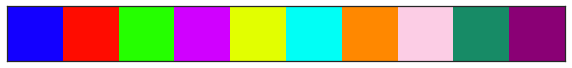

In [4]:
sns.palplot(color_list)

In [5]:
def tracked_orignal_change(orignal_image, new_mp):
    
    #mp = mp_ORSAggS4
    #orignal_image = trainX_OR1[0]
    df = new_mp._S.df.copy()
    SI = df.groupby('Subtypes').apply(lambda x:x.index.to_list())
    M, N, C = orignal_image.shape
    v = orignal_image.reshape(M*N*C, )
    arr_res = []
    for i, j in SI.items():
        j = [int(k.replace('p-',''))-1 for k in j]
        arr_1d = np.zeros(M*N, )
        arr_1d[j] = v[j]
        arr = arr_1d.reshape(M, N)  
        arr_res.append(arr)
    arr_tracked = np.stack(arr_res, axis=-1)
    return arr_tracked


In [6]:
if not os.path.exists(results_save_folder):
    os.makedirs(results_save_folder)

mp_train = loadmap(os.path.join(data_save_folder, 'train.mp'))
mp_test = loadmap(os.path.join(data_save_folder, 'test.mp'))


In [7]:
mp_train.info_distance.max()

1.6577623419656602

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() #(x_train, y_train), (x_test, y_test)

In [8]:
label_idxs = pd.Series(y_train).to_frame(name = 'labels').groupby('labels').apply(lambda x:x.index.to_list())

In [9]:
label_idxs

labels
0    [1, 2, 4, 10, 17, 26, 34, 48, 61, 64, 66, 67, ...
1    [16, 21, 38, 69, 71, 74, 78, 80, 86, 97, 98, 1...
2    [5, 7, 27, 37, 45, 53, 54, 65, 92, 123, 124, 1...
3    [3, 20, 25, 31, 47, 49, 50, 51, 58, 59, 70, 73...
4    [19, 22, 24, 28, 29, 68, 75, 76, 96, 117, 128,...
5    [8, 9, 12, 13, 30, 36, 43, 60, 62, 63, 82, 116...
6    [18, 32, 33, 39, 40, 55, 56, 72, 77, 95, 104, ...
7    [6, 14, 41, 46, 52, 83, 85, 87, 108, 119, 126,...
8    [23, 35, 57, 99, 100, 105, 109, 110, 130, 144,...
9    [0, 11, 15, 42, 44, 79, 84, 88, 89, 90, 93, 10...
dtype: object

In [10]:
X_OR1 = load(os.path.join(data_save_folder, '01_X_OR1.data'))
X_ORS1 = load(os.path.join(data_save_folder, '02_X_ORS1.data'))
X_ORSAgg1 = load(os.path.join(data_save_folder, '03_X_ORSAgg1.data'))
X_ORSAggC5 = load(os.path.join(data_save_folder, '04_X_ORSAggC5.data'))


In [11]:
mp_ORSAgg1 = loadmap(os.path.join(data_save_folder, 'mp_ORSAgg1.mp'))
mp_ORSAggC5 = loadmap(os.path.join(data_save_folder, 'mp_ORSAggC5.mp'))

## plot feature maps for all classes

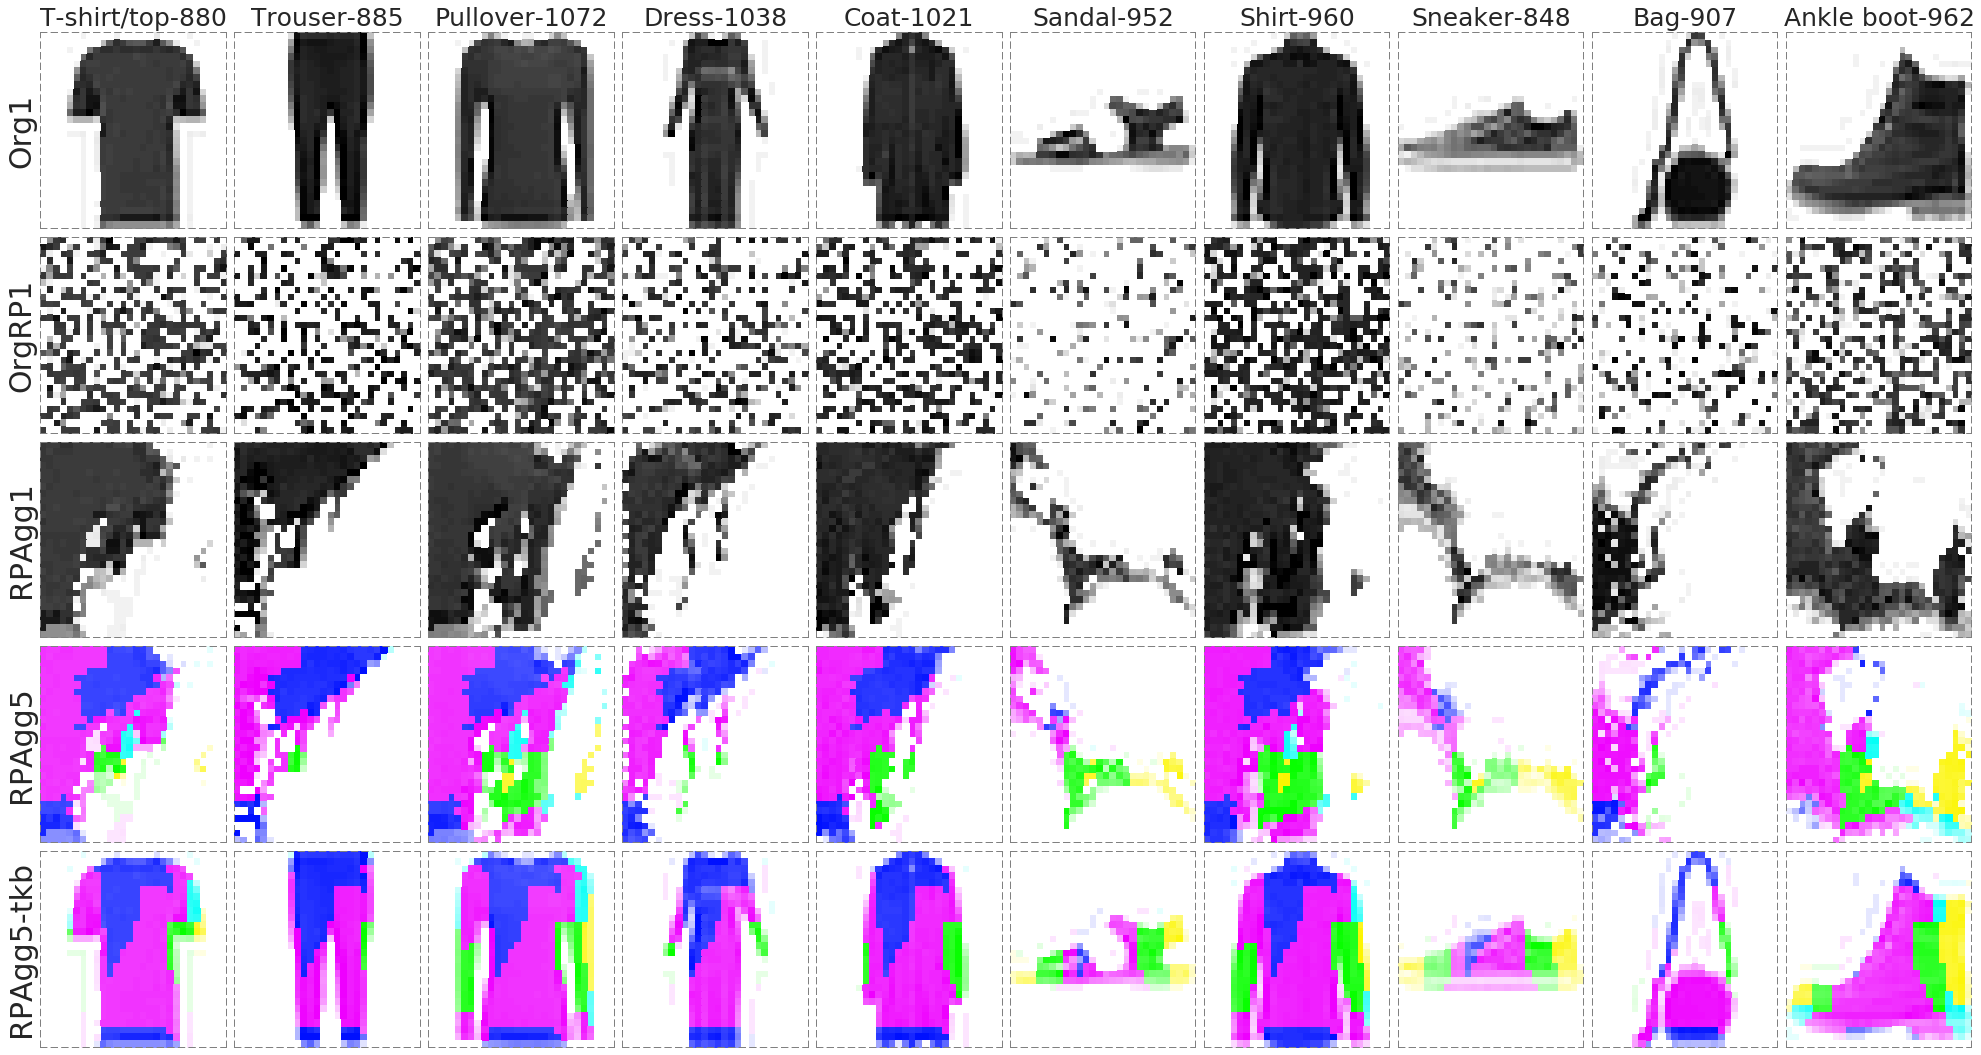

In [14]:
fmp_types = [X_OR1,  X_ORS1,  X_ORSAgg1, X_ORSAggC5] #, X_ORSAggC10
rows = ['Org1', 'OrgRP1', 'RPAgg1', 'RPAgg5'] #, 'RPAgg10'
cols = list(mnist_labels_dict.values())

image_idx = [pd.Series(label_idxs[i][:100]).sample(1, random_state = 88).to_list()[0] for i in range(len(label_idxs))]
cols = [i + '-%s' % j for i,j in zip(cols, image_idx)]

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(28,15), sharex = True, sharey = True)

fontsize = 30
## plot transformed images
for axc, X in zip(axes[:4], fmp_types):
    for ax, idx in zip(axc, image_idx):
        x = X[0][idx].astype(float)
        if x.shape[-1] == 1:
            imshow(x, ax=ax, color_list = ['black'], vmin = 0,  mode = 'light')
        else:
            imshow(x, ax=ax, color_list = pd.Series(mp_ORSAggC5.colormaps).tolist(), vmin = 0 , mode = 'light')
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': fontsize})
for ax, row in zip(axes[:4,0], rows):
    ax.set_ylabel(row, fontsize = 25)    
    
    
mps = [mp_ORSAggC5]
cols_name = ['RPAgg5-tkb']
for axc, mp in zip(axes[4:5], mps):
    for ax, idx in zip(axc, image_idx):
        x = tracked_orignal_change(X_OR1[0][idx], mp)
        imshow(x, ax=ax, color_list = pd.Series(mp_ORSAggC5.colormaps).tolist(), vmin = 0, mode = 'light')

for ax, row in zip(axes[4:5,0], cols_name):
    ax.set_ylabel(row, fontsize = fontsize)  
    
    

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.04, hspace=0.04)
fig.savefig(os.path.join(results_save_folder, '00_Fig2b.png'), bbox_inches='tight', dpi=400) 
fig.savefig(os.path.join(results_save_folder, '00_Fig2b.pdf'), bbox_inches='tight', dpi=400) 